# Simple RNN Chatbot for Understanding Sequential Learning

This notebook demonstrates how RNNs work by building a simple conversational chatbot.

**Key Learning Objectives:**
- Understanding RNN architecture and short-term memory
- Processing sequential text data
- Building a character-level/word-level generative model
- Training on conversational datasets

**Note:** RNNs have short-term memory limitations, so this chatbot will work best with simple, short conversations.


In [12]:
# Install required libraries
!pip install tensorflow numpy pandas matplotlib scikit-learn

# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.19.0


## Dataset Options for RNN Chatbot

We'll use one of these datasets:

1. **Cornell Movie Dialogue Corpus** (Recommended)
   - 220,579 conversational exchanges from movie scripts
   - Link: https://convokit.cornell.edu/documentation/movie.html
   - Hugging Face: https://huggingface.co/datasets/cornell-movie-dialog/cornell_movie_dialog

2. **Human Conversation Training Data** (Kaggle)
   - Aggregated conversational data
   - Link: https://www.kaggle.com/datasets/projjal1/human-conversation-training-data

3. **Custom Simple Dataset** (For quick testing)
   - We'll create a small dataset manually for demonstration

For this tutorial, we'll start with a simple custom dataset to understand RNN behavior, then show how to load Cornell dataset.


In [13]:
# Simple conversational dataset for demonstration
conversations = [
    "hi|hello",
    "hello|hi there",
    "how are you|i am good",
    "how are you|i am fine thank you",
    "what is your name|my name is chatbot",
    "what is your name|i am a bot",
    "bye|goodbye",
    "goodbye|see you later",
    "thank you|you are welcome",
    "thanks|no problem",
    "how old are you|i am a program",
    "where are you from|i am from the cloud",
    "what do you do|i chat with people",
    "are you human|no i am a bot",
    "good morning|good morning to you",
    "good night|sweet dreams",
    "help me|how can i help you",
    "tell me a joke|why did the chicken cross the road",
    "who are you|i am an ai assistant",
    "nice to meet you|nice to meet you too"
]

# Split into input-output pairs
input_texts = []
target_texts = []

for conversation in conversations:
    input_text, target_text = conversation.split('|')
    input_texts.append(input_text.lower())
    target_texts.append(target_text.lower())

print(f"Total conversations: {len(input_texts)}")
print(f"Sample Input: {input_texts[0]}")
print(f"Sample Target: {target_texts[0]}")


Total conversations: 20
Sample Input: hi
Sample Target: hello


## Data Preprocessing

For RNN to understand text, we need to:
1. **Tokenization**: Convert words/characters to numerical indices
2. **Padding**: Make all sequences the same length
3. **Vocabulary Creation**: Build a dictionary of unique tokens



In [14]:
# Combine all texts for tokenizer
all_texts = input_texts + target_texts

# Create tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")
print(f"Sample word-index mapping: {list(tokenizer.word_index.items())[:10]}")

# Convert texts to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Find maximum sequence length
max_input_length = max([len(seq) for seq in input_sequences])
max_target_length = max([len(seq) for seq in target_sequences])
max_length = max(max_input_length, max_target_length)

print(f"Max Sequence Length: {max_length}")

# Pad sequences
input_sequences_padded = pad_sequences(input_sequences, maxlen=max_length, padding='post')
target_sequences_padded = pad_sequences(target_sequences, maxlen=max_length, padding='post')

print(f"Input Shape: {input_sequences_padded.shape}")
print(f"Target Shape: {target_sequences_padded.shape}")


Vocabulary Size: 62
Sample word-index mapping: [('<OOV>', 1), ('you', 2), ('i', 3), ('are', 4), ('am', 5), ('how', 6), ('good', 7), ('a', 8), ('what', 9), ('is', 10)]
Max Sequence Length: 7
Input Shape: (20, 7)
Target Shape: (20, 7)


## Building Simple RNN Architecture

**Model Components:**
- **Embedding Layer**: Converts word indices to dense vectors
- **SimpleRNN/LSTM Layer**: Processes sequential information with memory
- **Dense Layer**: Output layer for prediction

We'll use LSTM instead of SimpleRNN for better performance (LSTM handles vanishing gradient better).


In [15]:
# Defining the parameters
embedding_dim = 64
rnn_units = 128
max_length = 20  # Adjust based on your data
vocab_size = 100  # This should come from your tokenizer


In [16]:
from tensorflow.keras.layers import SimpleRNN

# Model with Basic RNN (not LSTM)
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              name='embedding_layer'),

    SimpleRNN(rnn_units,  # <-- This is basic RNN
              return_sequences=True,
              name='simple_rnn_layer'),

    Dense(vocab_size,
          activation='softmax',
          name='output_layer')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
"""# Model parameters
embedding_dim = 64
rnn_units = 128

# Build the model with LSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              name='embedding_layer'),

    LSTM(rnn_units,
         return_sequences=True,
         name='lstm_layer'),

    Dense(vocab_size,
          activation='softmax',
          name='output_layer')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()
"""

"# Model parameters\nembedding_dim = 64\nrnn_units = 128\n\n# Build the model with LSTM\nmodel = Sequential([\n    Embedding(input_dim=vocab_size, \n              output_dim=embedding_dim, \n              input_length=max_length,\n              name='embedding_layer'),\n    \n    LSTM(rnn_units, \n         return_sequences=True,\n         name='lstm_layer'),\n    \n    Dense(vocab_size, \n          activation='softmax',\n          name='output_layer')\n])\n\n# Compile model\nmodel.compile(\n    optimizer='adam',\n    loss='sparse_categorical_crossentropy',\n    metrics=['accuracy']\n)\n\n# Model summary\nmodel.summary()\n"

## Training the Model

The RNN will learn to map input sequences to target sequences by:
- Processing input word by word
- Maintaining hidden state (short-term memory)
- Predicting the next word in the sequence


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.2250 - loss: 4.5159 - val_accuracy: 0.2500 - val_loss: 4.4650
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5905 - loss: 4.1246 - val_accuracy: 0.2500 - val_loss: 4.1815
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5429 - loss: 3.3506 - val_accuracy: 0.2500 - val_loss: 3.8407
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5107 - loss: 2.6367 - val_accuracy: 0.2143 - val_loss: 4.0597
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5619 - loss: 2.1943 - val_accuracy: 0.2143 - val_loss: 4.5114
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5631 - loss: 2.1898 - val_accuracy: 0.2143 - val_loss: 4.7792
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5083 - loss: 2.4295 - val_accuracy: 0.2143 - val_loss: 4.7929
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5310 - loss: 2.2319 - val_accuracy: 0.2143 - val_loss

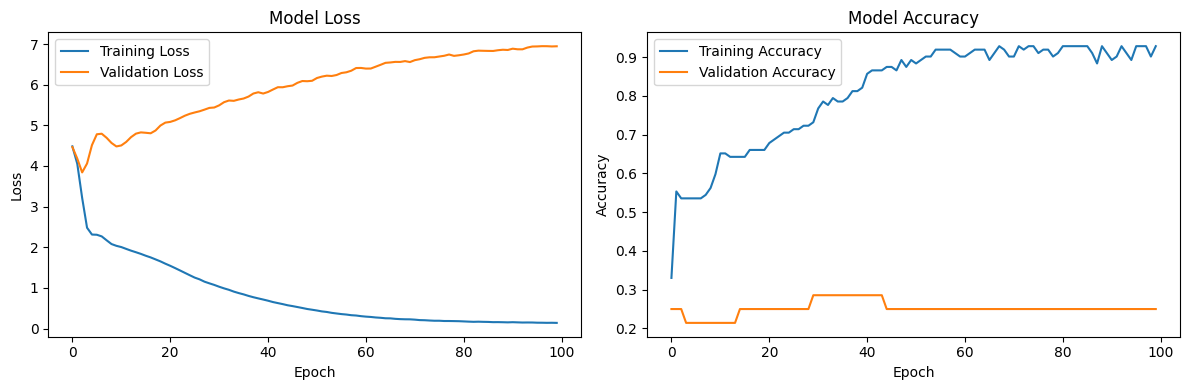

In [18]:
# Prepare target data (shift by one for next-word prediction)
# For simplicity, we'll train input->target mapping
X_train = input_sequences_padded
y_train = target_sequences_padded.reshape(target_sequences_padded.shape[0],
                                          target_sequences_padded.shape[1], 1)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
def generate_response(input_text, model, tokenizer, max_length):
    """
    Generate chatbot response for given input text
    """
    # Preprocess input
    input_text = input_text.lower()
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

    # Predict
    prediction = model.predict(input_padded, verbose=0)

    # Get predicted word indices (take argmax for each position)
    predicted_indices = np.argmax(prediction[0], axis=-1)

    # Convert indices back to words
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    response_words = [reverse_word_index.get(idx, '') for idx in predicted_indices if idx > 0]

    response = ' '.join(response_words)
    return response.strip()

# Test the function
test_inputs = ["hi", "how are you", "what is your name", "bye"]

print("=" * 50)
print("CHATBOT RESPONSES")
print("=" * 50)

for test_input in test_inputs:
    response = generate_response(test_input, model, tokenizer, max_length)
    print(f"You: {test_input}")
    print(f"Bot: {response}")
    print("-" * 50)


CHATBOT RESPONSES
You: hi
Bot: hello
--------------------------------------------------
You: how are you
Bot: i am fine thank you
--------------------------------------------------
You: what is your name
Bot: i am a bot
--------------------------------------------------
You: bye
Bot: goodbye
--------------------------------------------------


## Interactive Chat Session

Now you can chat with the bot interactively! Type 'quit' to exit.


In [20]:
def chat():
    """
    Interactive chatbot session
    """
    print("\n" + "="*50)
    print("Simple RNN Chatbot (Type 'quit' to exit)")
    print("="*50 + "\n")

    while True:
        user_input = input("You: ")

        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("Bot: Goodbye! Thanks for chatting!")
            break

        response = generate_response(user_input, model, tokenizer, max_length)
        print(f"Bot: {response}\n")

# Start chatting
chat()



Simple RNN Chatbot (Type 'quit' to exit)

You: hi
Bot: hello

You: hello
Bot: hi there

You: quit
Bot: Goodbye! Thanks for chatting!


## Understanding RNN Limitations

**Short-Term Memory Issues:**
- RNNs struggle with long sequences due to vanishing gradients
- They tend to "forget" information from earlier in the sequence
- LSTM improves this but still has limitations

**Why This Matters:**
- Simple chatbots work for short exchanges
- For complex conversations, use Transformers (like GPT) or advanced architectures
- RNNs are great for learning sequential patterns in bounded contexts


In [21]:
# Save the trained model
model.save('rnn_chatbot_model.h5')

# Save tokenizer
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save max_length
with open('max_length.txt', 'w') as f:
    f.write(str(max_length))

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!
